- **This code uses different strategies for computing the solution of the underlying MPC in a Closed-Loop DRTO implementation.**
- Th strategies are: 1. unconstrained, 2. constrained using binaries, and 3. constrained using MPCC
- A perfect MPC model is assumed and no disturbance model is added 

AUTHOR: Jose Matias <assumpcj@mcmaster.ca>
DATE: May 2023

In [1]:
using LinearAlgebra, JuMP, CPLEX, Ipopt, Plots

# Bioreactor Model

$\dfrac{d C}{d t} = D (C_{in} - C) - \dfrac{V_m C}{(K_s + C)} $ <br>
$ \dfrac{d P}{d t} = \dfrac{V_m C}{(K_s + C)} - DP $ <br>

where, <br>
$t$: time in hours \[h\] <br>
$C$: concentration of reactant (substrate) \[g/L\] <br>
$P$: concentration of product (biomass) \[g/L\] <br>
$C_{in}$: inlet concentration of substrate \[g/L\] <br>
$D$: ratio of flowrate to reactor volume \[1/h\] <br>
$V_m$: maximum reaction rate \[g/(h L)\] <br> 
$K_s$: reaction constant \[g/L\] <br>

- System measurement ($y$) - product concentration $P$ <br>
- System inputs ($u$) - inlet reactant concentration $C_{in}$ <br>
- Uncertain parameters ($\theta$) - maximum reaction rate $V_m$

In [2]:
# Sampling time
T = 1 #[h]
# Simulation time in sampling periods
nsim = 20
# Number of manipulated inputs
nu = 1
# Number of controlled outputs
ny = 1

# setting bounds (all arbitrary - talk to Lloyd - not in deviation form!!) 
uMax = 2.2 # 2.2 | 5.0
uMin = 0.0;

yspMax = 1.2 
yspMin = 0.0;

# Building CL-DRTO model

## Model linearization
- linearization is done using Matlab's functions ss and c2d (see BioReactorLinearization.m)
- sample time $\Delta t$ is consider as 1h
- linearization around point: $V_m = 0.5$ \[g/(h L)\], $K_s = 0.2$ \[g/L\], $D = 0.5$ \[1/h\], $C_{in,0} = 1$ \[g/L\], $C_{0} = 0.358$ \[g/L\], and $P_{0} = 0.642$ \[g/L\]

which leads to: <br>
$\bar{x}_{k+1} = A \bar{x}_k + B \bar{u}_k$ <br>
$\bar{y}_k = C \bar{u}_k$

where, <br>
$\bar{x} = \begin{bmatrix}
\bar{C}\\
\bar{P}
\end{bmatrix} =
\begin{bmatrix}
C - C_0\\
P - P_0
\end{bmatrix}$<br>
$\bar{u} = \bar{C}_{in} = C_{in} - C_{in,0}$<br>
$\bar{y} = \bar{P} = P - P_0$

In [3]:
# Linearization point
u0 = 1.5
x0 = [0.7179;0.7821]
y0 = 0.7821

# Number of states
nx = 2

# Possible initial conditions (deviation form)
xInit_0 = [0.1217 0.2229 0.3583 0.5256 0.7179;
           0.3783 0.5271 0.6418 0.7244 0.7821] .- x0
uInit_0 = [0.5 0.75 1.0 1.25 1.5] .- u0;

In [4]:
A = [0.4399 0; 0.1666 0.6065]
B = [0.3410; 0.05244]
C = [0 1];

CL-DRTO configuration

In [5]:
# DRTO sampling time
nDRTO = 4 # [h]
# Prediction horizon
pD = 20 + (8 - 1) # p = 8 *controller horizon
# Input control horizon 
mD = 20
# Objective function: target tracking (deviation form)
pTrack = 1 - y0 # [g/L]
# Soft upper bounds on P weight (deviation form)
pUB = 1.05 - y0 # [g/L]
wP = 100;

# Building MPC model

Controller configuration

In [6]:
# MPC sampling time
nMPC = 1 # [h]
# Output prediction horizon
p = 8
# Input control horizon 
m = 2
# Output weights
q = 1
# Input weights 
r = 1;

# N.B. same model as DRTO

## Building matrices for MPC


Given the following discrete state-space model:

$ x(k+1) = A \ x(k) + b \ u(k) $ <br>
$ y(k) = C \ x(k)$ <br>

Using the supperposition property of linear systems, we obtain the model outputs from instants $k+1$ to $k+j$ as:
$ y(k + 1|k) = C \ x(k + 1|k) = CA \ x(k) + CB \ u(k|k)$ <br>
$ y(k + 2|k) = CA^2 \ x(k) + CAB \ u(k|k) + CB \ u(k+1|k)$ <br>
$ y(k + 3|k) = CA^3 \ x(k) + CA^2B \ u(k|k) + CAB \ u(k+1|k) + CB \ u(k+2|k)$ <br>
$ ... $ <br>
$ y(k + j|k) = CA^j \ x(k) + CA^{j-1}B \ u(k|k) + CA^{j-2}B \ u(k+1|k) + \cdots + CB \ u(k + j -1|k)$ 

Suppose now that:<br>
$ u(k + m|k) = u(k + m + 1|k) = \cdots = u(k + p - 1|k)$

The equations above (when $j > m$) can then be re-written as:
$ y(k + m + 1|k) = CA^{m+1} \ x(k) + CA^{m}B \ u(k|k) + CA^{m-1}B \ u(k+1|k) + \cdots + [CAB + CB] \ u(k + m -1|k)$ <br>
$ y(k + m + 2|k) = CA^{m+2} \ x(k) + CA^{m+1}B \ u(k|k) + CA^{m}B \ u(k+1|k) + \cdots + [CA^2B + CAB + CB] \ u(k + m -1|k)$ <br>
$ ... $ <br>
$ y(k + pk) = CA^{p} \ x(k) + CA^{p-1}B \ u(k|k) + CA^{p-2}B \ u(k+1|k) + \cdots + [CA^{p-m}B + CA^{p-m-1}B + \cdots + CB] \ u(k + m -1|k)$

Thus, the vector of output predictions can be written as follows:

$
\begin{vmatrix}
y(k + 1|k)\\
y(k + 2|k)\\
\vdots \\
y(k + m|k) \\
y(k + m + 1|k)\\ 
\vdots \\
y(k + p|k)
\end{vmatrix}
= 
\begin{vmatrix}
CA\\
CA^{2}\\
\vdots \\
CA^{m} \\
CA^{m+1}\\ 
\vdots \\
CA^{p}
\end{vmatrix} \ x(k)
+
\begin{vmatrix}
CB        & 0         & \cdots & 0\\
CAB       & CB        & \cdots & 0\\
\vdots    & \vdots    & \cdots & \vdots\\
CA^{m-1}B & CA^{m-2}B & \cdots & CB\\
CA^{m}B   & CA^{m-1}B & \cdots & C\tilde{A}_1B\\ 
\vdots    & \vdots    & \cdots & \vdots\\
CA^{p-1}B & CA^{p-2}B & \cdots & C\tilde{A}_{p-m}B
\end{vmatrix} 
\begin{vmatrix}
u(k|k)\\
u(k + 2|k)\\
\vdots \\
u(k + m - 1|k) 
\end{vmatrix}
$

where: <br>
$\tilde{A}_1 = A + I, \quad \tilde{A}_2 = A^2 + A + I, \quad \tilde{A}_{p-m} = A^{p-m} + A^{p-m-1} + \cdots + I$

Simpifying, we have: <br>
$ \bar{y}(k) = \Psi \ x(k) + \Theta \ u(k) $ 

In [7]:
Psi = C*A
for ii in 2:p
    Psi = [Psi;  C*A^ii]
end

# Computing Dynamic Matrix
a = C*B
for ii in 2:p
    a = [a; C*A^(ii - 1)*B]
end
DynM = a


for ii in 1:(m - 2)
    a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
    DynM = [DynM  a]
end

# adjusting dynamic matrix for since p > m (last column)
b = C*B

Ai = I(nx)
for ii = 1:(p - m)
    Ai = Ai + A^ii
    b = [b;C*Ai*B]
end

Theta=[DynM [zeros(ny*(m-1),nu);b]];

The first term (output tracking) of the MPC objective function is: 

$ \sum_{j=1}^p (y(k + j|k) - y^{SP})^T \ Q \ (y(k + j|k) - y^{SP}) $

which can be written as:

$ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP}) $

where: 
$ \bar{Q} = diag\bigg( Q, \cdots, Q\bigg)$ - $p$ repetitions of $Q$

The second term (inputs movement penalization) of the MPC objective function is: 

$ \sum_{j=1}^{m-1} \Delta u(k + j|k)^T \ R \ \Delta u(k + j|k) $

We observe that:
$
\begin{vmatrix}
\Delta u(k|k)\\
\Delta u(k + 1|k)\\
\vdots \\
\Delta u(k + m - 1|k) 
\end{vmatrix}
= 
\begin{vmatrix}
u(k|k) - u(k - 1)\\
u(k + 1|k) - u(k|k)\\
\vdots \\
u(k + m - 1|k) - u(k + m - 2|k)
\end{vmatrix}
=
u_k - Mu_k - \bar{I} u(k - 1)
= (I_{nu,m} - M)u_k - \bar{I} u(k - 1)
= I_M u_k - \bar{I} u(k - 1)
$

in which:
$
M = 
\begin{vmatrix}
0_{nu} & 0_{nu} & \cdots & 0_{nu} & 0_{nu}\\
I_{nu} & 0_{nu} & \cdots & 0_{nu} & 0_{nu}\\
0_{nu} & I_{nu} & \cdots & 0_{nu} & 0_{nu}\\
\vdots & \vdots & \cdots & \vdots & \vdots\\
0_{nu} & 0_{nu} & \cdots & I_{nu} & 0_{nu}
\end{vmatrix}, \quad
\bar{I} = 
\begin{vmatrix}
I_{nu}\\
0_{nu}\\
0_{nu}\\
\vdots\\
0_{nu}
\end{vmatrix}
$

the second term can be written as:

$ (I_M u_k - \bar{I} u(k - 1))^T \ \bar{R} \ (I_M u_k - \bar{I} u(k - 1)) $

where: 
$ \bar{R} = diag\bigg( R, \cdots, R\bigg)$ - $m$ repetitions of $R$

In [8]:
# Creating Qbar and Rbar matrices
Qbar = Diagonal([q for ii in 1:p])
Rbar = Diagonal([r for ii in 1:m])

# Creating input movement OF penalty matrix 
M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
Ibar=[I(nu); zeros(nu*(m-1),nu)]
IM = I(nu*m) - M';

The objective function then can be reduced to a quadratic function of the form:
$$ J_k = u_k^T \ H \ u_k + 2c_f^T \ u_k + c $$

where:

$H = \Theta^T \ \bar{Q} \ \Theta + I_M^T \ \bar{R} \ I_M$ <br>
$c_f^T = (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ \Theta + u(k-1)^T\bar{I}^T \ \bar{R} \ I_M$ <br>
$c = (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP}) + u(k-1)^T\bar{I}^T \ \bar{R} \ \bar{I} \ u(k-1)$

In [9]:
# Matrix H
H = Theta'*Qbar*Theta+IM'*Rbar*IM;

## Constrained MPC optimization problem

Since we are considering constraints, the optimization problem reads as:

$$ min_{u_k} J_k = u_k^T \ H \ u_k + 2c_f^T \ u_k + c $$

$$ s.t.: u_{min} \leq u_k \leq u_{max}  \quad k = 1,\ldots,m $$ 
 
considering m = 3, we can rewrite the constraints as:

$ u_k - u_{max} \leq 0 \quad k = 1,2,3  $ <br>
$ u_{min} - u_k \leq 0 \quad k = 1,2,3  $ <br>

## Solving problem via KKT

The Lagrangian of the problem above is: 
$$ L = u_k^T \ H \ u_k + 2c_f^T \ u_k + c + 
\begin{vmatrix}
\mu_{UB,1} \ \mu_{UB,2} \ \mu_{UB,3} \ \mu_{LB,1} \ \mu_{LB,2} \ \mu_{LB,3}
\end{vmatrix} 
\begin{vmatrix}
u_1 - u_{max} \\ u_2 - u_{max} \\ u_3 - u_{max} \\ u_{min} - u_1 \\ u_{min} - u_2 \\ u_{min} - u_3
\end{vmatrix}
$$

The KKT conditions can be written as

- Stationarity of the Lagrangian <br>
$ \nabla_u L = 
\begin{vmatrix}
u_{1} & u_{2} & u_{3}
\end{vmatrix} 
\ H + c_f^T +  
\begin{vmatrix}
\mu_{UB,1} & \mu_{UB,2} & \mu_{UB,3} & \mu_{LB,1} & \mu_{LB,2} & \mu_{LB,3}
\end{vmatrix} 
\begin{vmatrix}
1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ -1 & 0 & 0 \\ 0 & -1 & 0 \\ 0 & 0 & -1
\end{vmatrix}
$ <br>

- Primal Feasibility <br>
$
\begin{vmatrix}
u_1 - u_{max} \\ u_2 - u_{max} \\ u_3 - u_{max} \\ u_{min} - u_1 \\ u_{min} - u_2 \\ u_{min} - u_3
\end{vmatrix}
\leq 0
$ <br>

- Dual Feasibility <br>
$
\begin{vmatrix}
\mu_{UB,1} \\ \mu_{UB,2} \\ \mu_{UB,3} \\ \mu_{LB,1} \\ \mu_{LB,2} \\ \mu_{LB,3}
\end{vmatrix}
\geq 0
$ <br>

- Complementarity Slackness <br>
$
\begin{vmatrix}
\mu_{UB,1} & \mu_{UB,2} & \mu_{UB,3} & \mu_{LB,1} & \mu_{LB,2} & \mu_{LB,3}
\end{vmatrix}
\begin{vmatrix}
u_1 - u_{max} \\ u_2 - u_{max} \\ u_3 - u_{max} \\ u_{min} - u_1 \\ u_{min} - u_2 \\ u_{min} - u_3
\end{vmatrix}
= 0
$

# Solving complementarity slackness using binaries

Defining: <br>
$
\boldsymbol{g} := 
\begin{vmatrix}
u_1 - u_{max} \\ u_2 - u_{max} \\ u_3 - u_{max} \\ u_{min} - u_1 \\ u_{min} - u_2 \\ u_{min} - u_3
\end{vmatrix}
$ <br>

The complementarity slackness becomes: <br>
$ \boldsymbol{\mu}^\top \ \boldsymbol{g} = 0 $

which can be rearranged into linear constraints using the big-M strategy:<br>
for $j = 1,\ldots,n_g$ <br>
$ \boldsymbol{\mu}_j \geq 0 $ <br>
$ \boldsymbol{\mu}_j \leq MY_j $ <br>
$ \boldsymbol{g}_j \leq 0 $ <br>
$ \boldsymbol{g}_j \geq M(1 - Y_j) $ <br>

where: <br>
$M$ is a large constant <br>
and $Y = \{0,1\}$ is a binary variable

## Function: solving CL-DRTO + constrained MPC (binaries - big-M)
- Given initial state and previous plant input

In [10]:
# Parameters
# matrix to compute the gradients of the input bound constraints
conMatrix = [I(m); -I(m)]; 

# big-M implementation
bigM_mu = 1000
bigM_u = 100;

In [11]:
function CLDRTO_con_bin(xInit,uInit)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant

    # Define subproblem model
    m_con_bin = Model(CPLEX.Optimizer)
    # set_silent(m_con_bin) # avoid printing

    ####################
    # Set up variables #
    ####################
    # DRTO states
    @variable(m_con_bin, x[1:pD, 1:nx])
    # DRTO model outputs
    @variable(m_con_bin, y[1:pD])

    # SP model outputs
    @variable(m_con_bin, (yspMin - y0) ≤ ysp[1:pD] ≤ (yspMax  - y0))
    
    # inputs computed by MPCs
    @variable(m_con_bin, u[1:pD,1:m])
    @variable(m_con_bin, mu_g[1:pD,1:(2*m)] ≥ 0) # upper and lower bounds for each input
    @variable(m_con_bin, Y_ub[1:pD,1:m], Bin)
    @variable(m_con_bin, Y_lb[1:pD,1:m], Bin)
    
    # slacks for P soft constraint
    @variable(m_con_bin, delta_p[1:pD] >= 0)

    #############################
    # Set up objective function #
    #############################
    # track p with penalization for soft constraint P
    @objective(m_con_bin, Min, sum((y[kk] - pTrack)^2 + wP*delta_p[kk]^2 for kk in 1:pD))

    #####################
    # Set up DRTO model #
    #####################
    # Dynamic RTO model (linear)
    @constraint(m_con_bin, CLDRTO_dyn_model_1, x[1,:] .== A*xInit + B*uInit)
    @constraint(m_con_bin, CLDRTO_dyn_model[kk=1:(pD - 1)], x[kk + 1,:] .== A*x[kk,:] + B*u[kk,1])
    @constraint(m_con_bin, CLDRTO_model_out[kk=1:pD], y[kk] == dot(C,x[kk,:]))

    ##########################################
    # Set up MPC constraints and expressions #
    ##########################################    
    @expression(m_con_bin, cfT_1, (Psi*x[1,:] - ysp[1:p])'*Qbar*Theta - uInit'*Ibar'*Rbar*IM)
    @expression(m_con_bin, cfT[kk=2:mD], (Psi*x[kk,:] - ysp[kk:(kk + p - 1)])'*Qbar*Theta - u[kk-1,1]'*Ibar'*Rbar*IM)
    
    # stationarity
    @constraint(m_con_bin, MPC_sol_1, u[1,:]'*H + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
    @constraint(m_con_bin, MPC_sol[kk=2:mD], u[kk,:]'*H + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

    # primal feasibility
    @constraint(m_con_bin, MPC_u_upper[kk = 1:mD,uu = 1:m], u[kk,uu] - (uMax - u0) <= 0)
    @constraint(m_con_bin, MPC_u_lower[kk = 1:mD,uu = 1:m], (uMin - u0) - u[kk,uu] <= 0)
    
    # big-M implementation
    @constraint(m_con_bin, bigM_1[kk = 1:mD,uu = 1:m], mu_g[kk,uu] <= bigM_mu*Y_ub[kk,uu])
    @constraint(m_con_bin, bigM_2[kk = 1:mD,uu = 1:m], mu_g[kk,uu + m] <= bigM_mu*Y_lb[kk,uu])
    @constraint(m_con_bin, bigM_3[kk = 1:mD,uu = 1:m], u[kk,uu] - (uMax - u0) >= -bigM_u*(1 - Y_ub[kk,uu]))
    @constraint(m_con_bin, bigM_4[kk = 1:mD,uu = 1:m], (uMin - u0) - u[kk,uu] >= -bigM_u*(1 - Y_lb[kk,uu]))

    @constraint(m_con_bin, compSlack[kk = 1:mD,uu = 1:m], Y_ub[kk,uu] + Y_lb[kk,uu] ≤ 1)

    # fixing input after mD
    @constraint(m_con_bin, control_horizon[kk=(mD+1):pD], u[kk] == u[mD]);
    
    # P soft constraint
    @constraint(m_con_bin, soft_P[kk=1:pD], y[kk] - delta_p[kk] <= pUB)

    # @show model_ms
    
    optimize!(m_con_bin)
    flag = termination_status(m_con_bin)
    # #primal_status(m)
    
    #calling values of the solved problem
    o = objective_value(m_con_bin)
    uArray = value.(u)
    yspArray = value.(ysp)
    yArray = value.(y)
    
    # lagrange multipliers associated with the nonantecipativity constraints
    #λ = dual.(control_horizon)
    
    return Dict('o' => o, 'f' => flag, 'u' => uArray, 'y' => yArray, 's' => yspArray)
end;

# Solving Complementary using MPCC

The complementarity slackness is now moved to the objective function: <br>

$ max_{u_k} \ \boldsymbol{\mu}^\top \ \boldsymbol{g} $ <br>
s.t.: <br>
$ \nabla L = 0 $ <br>
$ u - u_{max} \leq 0 \quad j = 1,\ldots,n_g $ <br>
$ u_{min} - u \leq 0 \quad j = 1,\ldots,n_g $ <br>
$ \boldsymbol{\mu}_j \geq 0 \quad j = 1,\ldots,n_g $ <br>

## Function: solving CL-DRTO + constrained MPC (MPCC)
- Given initial state and previous plant input

In [12]:
function CLDRTO_con_mpec(xInit,uInit,pi_bar)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant
    # pi_bar - weight for the complementarity relaxation term in OF

    # Define subproblem model
    m_con_mpec = Model(Ipopt.Optimizer)
    set_silent(m_con_mpec) # avoid printing

    ####################
    # Set up variables #
    ####################
    # DRTO states
    @variable(m_con_mpec, x[1:pD, 1:nx])
    # DRTO model outputs
    @variable(m_con_mpec, y[1:pD])

    # SP model outputs
    @variable(m_con_mpec, (yspMin - y0) ≤ ysp[1:pD] ≤ (yspMax - y0))
    
    # inputs computed by MPCs
    @variable(m_con_mpec, u[1:pD,1:m])
    @variable(m_con_mpec, mu_g[1:pD,1:(2*m)] ≥ 0) # upper and lower bounds for each input
    
    # slacks for P soft constraint
    @variable(m_con_mpec, delta_p[1:pD] >= 0)

    #####################
    # Set up DRTO model #
    #####################
    # Dynamic RTO model (linear)
    @constraint(m_con_mpec, CLDRTO_dyn_model_1, x[1,:] .== A*xInit + B*uInit)
    @constraint(m_con_mpec, CLDRTO_dyn_model[kk=1:(pD - 1)], x[kk + 1,:] .== A*x[kk,:] + B*u[kk,1])
    @constraint(m_con_mpec, CLDRTO_model_out[kk=1:pD], y[kk] == dot(C,x[kk,:]))

    ##########################################
    # Set up MPC constraints and expressions #
    ##########################################    
    @expression(m_con_mpec, cfT_1, (Psi*x[1,:] - ysp[1:p])'*Qbar*Theta - uInit'*Ibar'*Rbar*IM)
    @expression(m_con_mpec, cfT[kk=2:mD], (Psi*x[kk,:] - ysp[kk:(kk + p - 1)])'*Qbar*Theta - u[kk-1,1]'*Ibar'*Rbar*IM)
    
    # stationarity
    @constraint(m_con_mpec, MPC_sol_1, u[1,:]'*H + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
    @constraint(m_con_mpec, MPC_sol[kk=2:mD], u[kk,:]'*H + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

    # primal feasibility
    @expression(m_con_mpec, g_u_u[kk = 1:mD,uu = 1:m], u[kk,uu] - (uMax - u0))
    @expression(m_con_mpec, g_u_l[kk = 1:mD,uu = 1:m], (uMin - u0) - u[kk,uu])

    @constraint(m_con_mpec, MPC_c_upper[kk = 1:mD,uu = 1:m], g_u_u[kk,uu] <= 0)
    @constraint(m_con_mpec, MPC_c_lower[kk = 1:mD,uu = 1:m], g_u_l[kk,uu] <= 0)
    
    # fixing input after mD
    @constraint(m_con_mpec, control_horizon[kk=(mD+1):pD], u[kk] == u[mD]);
    
    # P soft constraint
    @constraint(m_con_mpec, soft_P[kk=1:pD], y[kk] - delta_p[kk] ≤ pUB)

    #############################
    # Set up objective function #
    #############################
    # minimize input usage to bring y to target + penalization if output leaves target band
    @objective(m_con_mpec, Min, 
            sum((y[kk] - pTrack)^2 + wP*delta_p[kk]^2 for kk in 1:pD)
            - pi_bar*sum(
                  sum(mu_g[kk,jj]*g_u_u[kk,jj] for jj = 1:m) +
                  sum(mu_g[kk,jj + m]*g_u_l[kk,jj] for jj = 1:m)
                  for kk = 1:mD)
            )
    # @show model_ms
    
    optimize!(m_con_mpec)
    flag = termination_status(m_con_mpec)
    # #primal_status(m)
    
    #calling values of the solved problem
    o = objective_value(m_con_mpec)
    uArray = value.(u)
    yspArray = value.(ysp)
    yArray = value.(y)
    muArray = value.(mu_g)
    g_u_Array = uArray - uMax*ones(pD,m)
    g_l_Array = uMin*ones(pD,m) - uArray
    
    return Dict('o' => o, 'f' => flag, 'u' => uArray, 'y' => yArray, 's' => yspArray, 'm' => muArray, 'g' => [g_u_Array g_l_Array])
end;

# Finding the weights for the interior penalty method for MPCC solution

1


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



"Max value of multiplier: 463.3260968512662"

2

"Max value of multiplier: 80.4610800667166"

3

"Max value of multiplier: 54.80503002739954"

4

"Max value of multiplier: 260.49050431419647"

5

"Max value of multiplier: 0.4782620867500503"

6

"Max value of multiplier: 0.5175407235978966"

7

"Max value of multiplier: 0.46340528473795034"

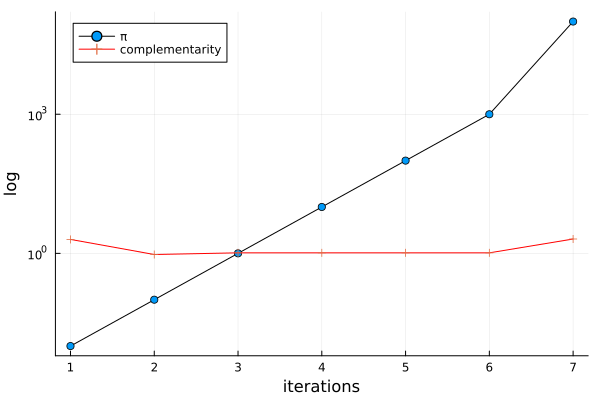

In [13]:
# trial weights for complementarity relaxation OF term
pi_w_Array = [0.01 0.1 1 10 10^2 10^3 10^5] 

nTest = length(pi_w_Array)

comp_gap = Vector{Float64}(undef,nTest) 

for ii = 1:nTest
    display(ii)
    
    # solving problem with relaxed complementarity slackness
    sol_temp = CLDRTO_con_mpec(xInit_0[:,1],uInit_0[1],pi_w_Array[ii])

    # display 
    display("Max value of multiplier: $(maximum(sol_temp['m']))")
    
    # checking the complementarity gap for all MPC's
    com_gap_temp = 0
    for kk = 1:mD
        temp = abs(sum(sol_temp['m'][kk,jj]*sol_temp['g'][kk,jj] for jj = 1:(2*m)))
        com_gap_temp = com_gap_temp + temp
    end
    
    # saving information
    comp_gap[ii] = com_gap_temp
    
    
end

gr()

p1 = plot(1:nTest,pi_w_Array', yaxis="log",xaxis="iterations",linecolor = :black,marker= :circle,
            xticks = 1:nTest,legend=:topleft,yscale=:log10)
p1 = plot!(1:nTest,comp_gap, linecolor = :red,marker= :cross,xticks = 1:nTest,yscale=:log10,legend=:topleft)
p1.series_list[1][:label] = "π"
p1.series_list[2][:label] = "complementarity"

display(p1)


In [19]:
display(comp_gap)

7-element Vector{Float64}:
 1.9950924359235744
 0.9431188786415408
 1.026251556851962
 1.0247614875558375
 1.026336766461309
 1.0254499214961308
 2.0392691798230898

## Function: solving CL-DRTO + unconstrained MPC (for comparison)
- Given initial state and previous plant input

In [14]:
function CLDRTO_unc(xInit,uInit)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant

    # Define subproblem model
    m_unc = Model(CPLEX.Optimizer)
    set_silent(m_unc) # avoid printing

    ####################
    # Set up variables #
    ####################
    # DRTO states
    @variable(m_unc, x[1:pD, 1:nx])
    # DRTO model outputs
    @variable(m_unc, y[1:pD])

    # SP model outputs
    @variable(m_unc, (yspMin - y0) ≤ ysp[1:pD] ≤ (yspMax - y0))

    # inputs computed by MPCs
    @variable(m_unc, (uMin - u0) <= u[1:pD,1:m] <= (uMax - u0))
    
    # slacks for P soft constraint
    @variable(m_unc, delta_p[1:pD] >= 0)

    #############################
    # Set up objective function #
    #############################
    # minimize input usage to bring y to target + penalization if output leaves target band
    @objective(m_unc, Min, sum((y[kk] - pTrack)^2 + wP*delta_p[kk]^2 for kk in 1:pD))

    ######################################
    # Set up constraints and expressions #
    ######################################
    # Dynamic RTO model (linear)
    @constraint(m_unc, CLDRTO_dyn_model_1, x[1,:] .== A*xInit + B*uInit)
    @constraint(m_unc, CLDRTO_dyn_model[kk=1:(pD - 1)], x[kk + 1,:] .== A*x[kk,:] + B*u[kk,1])
    @constraint(m_unc, CLDRTO_model_out[kk=1:pD], y[kk] == dot(C,x[kk,:]))

    # Unconstrained MPC solution
    @expression(m_unc, cfT_1, (Psi*x[1,:] - ysp[1:p])'*Qbar*Theta - uInit'*Ibar'*Rbar*IM)
    @expression(m_unc, cfT[kk=2:mD], (Psi*x[kk,:] - ysp[kk:(kk + p - 1)])'*Qbar*Theta - u[kk-1,1]'*Ibar'*Rbar*IM)

    @constraint(m_unc, MPC_sol_1, H*u[1,:] + cfT_1' .== 0)
    @constraint(m_unc, MPC_sol[kk=2:mD], H*u[kk,:] + cfT[kk]' .== 0)
    
    # fixing input after mD
    @constraint(m_unc, control_horizon[kk=(mD+1):pD], u[kk] == u[mD]);

    # y (DRTO) inside target quality band
    @constraint(m_unc, softP[kk=1:pD], y[kk] - delta_p[kk] <= pUB)

    # @show model_ms
    
    optimize!(m_unc)
    flag = termination_status(m_unc)
    # #primal_status(m)
    
    #calling values of the solved problem
    o = objective_value(m_unc)
    uArray = value.(u)
    yspArray = value.(ysp)
    yArray = value.(y)
    
    return Dict('o' => o, 'f' => flag, 'u' => uArray, 'y' => yArray, 's' => yspArray)
end;

# Plotting results for comparison

In [15]:
sol_con_bin = CLDRTO_con_bin(xInit_0[:,1],uInit_0[1])

# Get values for plotting
uTraj_bin = Vector{Float64}(undef,pD) 
yspTraj_bin = Vector{Float64}(undef,pD)
yTraj_bin = Vector{Float64}(undef,pD)

for kk in 1:pD
    yTraj_bin[kk] = sol_con_bin['y'][kk] + y0
    yspTraj_bin[kk] = sol_con_bin['s'][kk] + y0
    uTraj_bin[kk] = sol_con_bin['u'][kk] + u0
end;

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 2 times.
MIQP Presolve eliminated 137 rows and 80 columns.
MIQP Presolve added 80 rows and 0 columns.
MIQP Presolve modified 160 coefficients.
Aggregator did 34 substitutions.
Reduced MIQP has 344 rows, 291 columns, and 1233 nonzeros.
Reduced MIQP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 41 nonzeros.
Presolve time = 0.00 sec. (0.89 ticks)
Probing fixed 7 vars, tightened 220 bounds.
Probing time = 0.00 sec. (3.30 ticks)
Tried aggregator 2 times.
MIQP Presolve eliminated 25 rows and 15 columns.
MIQP Presolve modified 158 coefficients.
Aggregator did 8 substitutions.
Reduced MIQP has 311 rows, 268 columns, and 1209 nonzeros.
Reduced MIQP has 73 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 40 nonzeros.
Presolve time = 0.00 sec. (0.65 ticks)
Classifier predicts products in MIQP should be linearized.
Probing fixed 0 vars, tightened 71

In [16]:
sol_con_mpcc = CLDRTO_con_mpec(xInit_0[:,1],uInit_0[1],10^2)

#test = maximum(sol_con_mpcc['m'])
#display(test)

# Get values for plotting
uTraj_mpcc = Vector{Float64}(undef,pD) 
yspTraj_mpcc = Vector{Float64}(undef,pD)
yTraj_mpcc = Vector{Float64}(undef,pD)

for kk in 1:pD
    yTraj_mpcc[kk] = sol_con_mpcc['y'][kk] + y0
    yspTraj_mpcc[kk] = sol_con_mpcc['s'][kk] + y0
    uTraj_mpcc[kk] = sol_con_mpcc['u'][kk] + u0
end;

In [17]:
sol_unc = CLDRTO_unc(xInit_0[:,1],uInit_0[1])

# Get values for plotting
uTraj_unc = Vector{Float64}(undef,pD) 
yspTraj_unc = Vector{Float64}(undef,pD)
yTraj_unc = Vector{Float64}(undef,pD)

for kk in 1:pD
    yTraj_unc[kk] = sol_unc['y'][kk] + y0
    yspTraj_unc[kk] = sol_unc['s'][kk] + y0
    uTraj_unc[kk] = sol_unc['u'][kk] + u0
end;

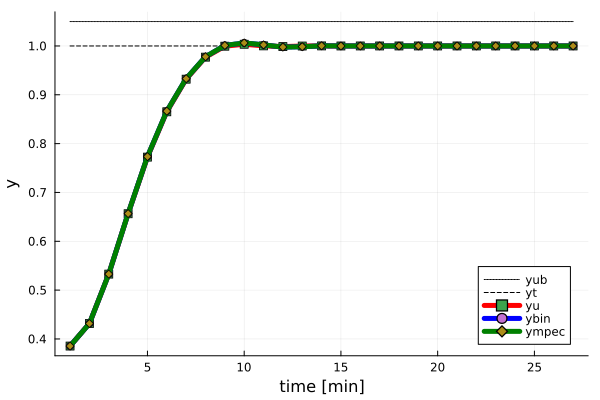

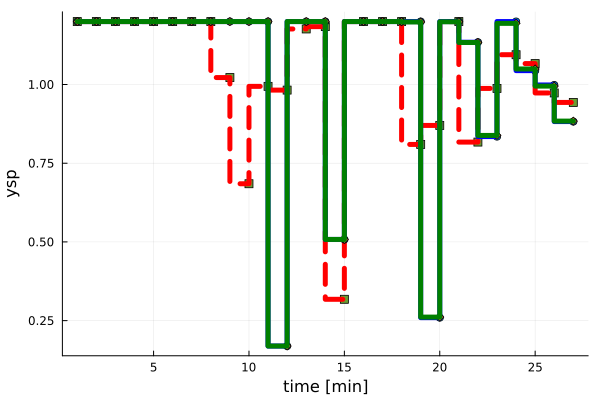

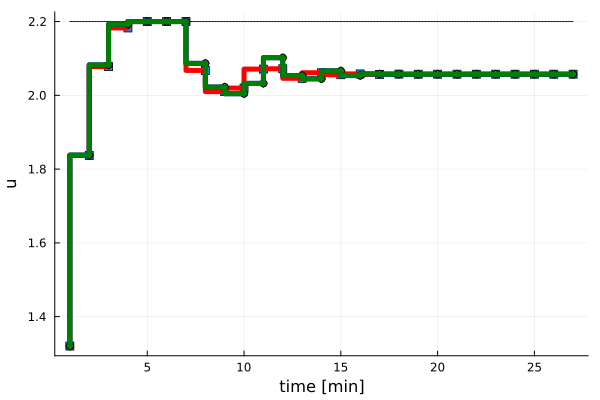

In [18]:
# time series for plotting
ts = Vector{Float64}(undef,pD) 
for i in 1:pD
    ts[i] = 1*i
end

gr()

p1 = plot(ts,1.05*ones(length(ts)),linestyle = :dot,linecolor = :black)
p1 = plot!(ts,1.00*ones(length(ts)),linestyle = :dash,linecolor = :black)
p1 = plot!(ts,yTraj_unc,linewidth=5,marker= :square,linecolor = :red)
p1 = plot!(ts,yTraj_bin,linewidth=5,marker= :circle,xaxis="time [min]",yaxis="y",linecolor = :blue)
p1 = plot!(ts,yTraj_mpcc,linewidth=5,marker= :diamond,linecolor = :green)
p1.series_list[1][:label] = "yub"
p1.series_list[2][:label] = "yt"
p1.series_list[3][:label] = "yu"
p1.series_list[4][:label] = "ybin"
p1.series_list[5][:label] = "ympec"
display(p1)

p2 = plot(ts,yspTraj_unc,linestyle=:dash,linewidth=5,marker= :square,linecolor = :red,linetype=:steppre,legend=false)
p2 = plot!(ts,yspTraj_bin,linewidth=5,marker= :circle,xaxis="time [min]",yaxis="ysp",linecolor = :blue,linetype=:steppre,legend=false)
p2 = plot!(ts,yspTraj_mpcc,linewidth=5,marker= :diamond,linecolor = :green,linetype=:steppre,legend=false)

display(p2)

p3 = plot(ts,uMax*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time [min]", yaxis="u",legend=false)
p3 = plot!(ts,uTraj_unc,linewidth=5,marker= :square,linecolor = :red, linetype=:steppre,legend=false)
p3 = plot!(ts,uTraj_bin,linewidth=5,marker= :circle,linecolor = :blue, linetype=:steppre,legend=false)
p3 = plot!(ts,uTraj_mpcc,linewidth=5,marker= :diamond,linecolor = :green, linetype=:steppre,legend=false)
display(p3)